In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from functools import partial
import matplotlib.pyplot as plt
import jax.scipy as jsp
import scipy as sp

from infiniteDoob.landmarks import *
from infiniteDoob.metric import *
from infiniteDoob.plotting import *
from infiniteDoob.Eulerian import *

I0000 00:00:1699466899.780202       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
key = jax.random.PRNGKey(0)

M = landmarks(N=64, m=2)
metric.initialize(M)
Eulerian.initialize(M)

In [4]:
def downsample_shape(M, key=None, random=False):
    if random:
        assert key is not None
        phis = jax.random.uniform(key, (M.N,), minval=0., maxval=2.0*jnp.pi)
    else:
        phis = jnp.linspace(0., 2.0*jnp.pi, M.N)
        phis = jnp.sort(phis)
    return M.coords(jnp.vstack([jnp.cos(phis),
                                jnp.sin(phis)]).T.ravel())

q0 = downsample_shape(M, key=key, random=False)

coords_to_pixels = lambda q, coords_transfer_scale: (coords_transfer_scale * q.reshape((-1, M.m)) + jnp.array([M.N/2., M.N/2.])[jnp.newaxis, :])

In [7]:
def setup():
    coords_range = [-1.5, 1.5]
    kernel_amp_coords = 0.7
    kernel_scale_coords = 0.2
    sigma_deviation = 3.0
    dW_resolution = 64
    n_steps = 10
    T = 0.1

    x_left, x_right = coords_range
    delta_p = (x_right - x_left) / dW_resolution 
    kernel_amp_pixels = kernel_amp_coords * delta_p
    kernel_scale_pixels = kernel_scale_coords / delta_p
    kernel_edge_pixels = kernel_scale_pixels * sigma_deviation
    kernel_dim_pixels = int(2 * kernel_edge_pixels) + 1
    kernel_span_pixels = jnp.linspace(-kernel_edge_pixels, kernel_edge_pixels, kernel_dim_pixels)
    print(f"kernel dim: {kernel_dim_pixels} x {kernel_dim_pixels}")

    # Theoretical covariance of dW
    make_square = lambda A: A.reshape((jnp.sqrt(A.size).astype('int'), jnp.sqrt(A.size).astype('int'))) 
    kQ_coords = lambda q, kernel_amp_coords, kernel_scale_coords: 0.5 * kernel_amp_coords**2 * kernel_scale_coords**2 * jnp.pi * jnp.exp(-0.5 / kernel_scale_coords**2 * jnp.sum(jnp.square(q), 2)) 
    kQ_q_coords = lambda q1, q2, kernel_amp_coords, kernel_scale_coords: kQ_coords(q1.reshape((-1, M.m))[:, jnp.newaxis, :] - q2.reshape((-1, M.m))[jnp.newaxis, :, :],\
                                                                                kernel_amp_coords, \
                                                                                kernel_scale_coords)  
    Q_coords = lambda q, kernel_amp_coords, kernel_scale_coords: make_square(jnp.einsum('ij,kl->ikjl', kQ_q_coords(q, q, kernel_amp_coords, kernel_scale_coords), jnp.eye(2)))  


    # Empirical covariance
    gaussian = lambda span, loc, scale: jnp.exp(-1.0 * ((span - loc) / scale)**2)
    gaussian_pixels = partial(gaussian, loc=0.)
    k_Q_half_pixels = lambda kernel_amp_pixels, kernel_scale_pixels: kernel_amp_pixels \
                                                                * gaussian_pixels(span=kernel_span_pixels, scale=kernel_scale_pixels) \
                                                                * gaussian_pixels(span=kernel_span_pixels[:, None], scale=kernel_scale_pixels)
    dW_pixels = lambda key: jnp.sqrt(T / n_steps) * jax.random.normal(key, (n_steps, dW_resolution, dW_resolution, M.m))

    coords_to_pixels = lambda q: (q - x_left) / delta_p
    pixels_to_coords = lambda x: x * delta_p + x_left

    Q_half_dW_pixels = jax.vmap(
        jax.vmap(
            lambda kernel_amp_pixels, kernel_scale_pixels, _dW_pixels: jsp.signal.convolve(_dW_pixels, 
                                                                                        k_Q_half_pixels(kernel_amp_pixels, 
                                                                                                        kernel_scale_pixels), 
                                                                                        mode='same'),
            (None, None, 2),
            2
        ),
        (None, None, 0),
        0
    )
    interpolate = jax.vmap(
        lambda _Q_half_dW_pixels, q: jsp.ndimage.map_coordinates(_Q_half_dW_pixels.T, coords_to_pixels(q).T, order=1),
        (2, None),
        1
    )
    # Q_half_dW_pixels = lambda _dW_pixels, _Q_half_pixels: jsp.signal.convolve2d(_dW_pixels, _Q_half_pixels, mode='same')
    # interpolate = lambda _Q_half_dW_pixels, x: jsp.ndimage.map_coordinates(_Q_half_dW_pixels.T, x.T, order=1)

    # gaussian = lambda x, loc, scale: jnp.exp(-1.0 * ((x - loc) / scale)**2)
    # k_Q_half = lambda amp, scale: amp * gaussian(x, loc=0., scale=scale) * gaussian(x[:, None], loc=0., scale=scale)
    # k_Q = lambda disp, amp, scale: 0.5 * amp**2 * scale**2 * jnp.pi * jnp.exp(-0.5 / scale**2 * jnp.sum(jnp.square(disp), 2))


    # kQ_q = lambda q1, q2, amp, scale: k_Q(q1.reshape((-1, M.m))[:, np.newaxis, :] - q2.reshape((-1, M.m))[np.newaxis, :, :], amp, scale)  
    # Q = lambda q, amp, scale: make_square(jnp.einsum('ij,kl->ikjl', kQ_q(q, q, amp, scale), jnp.eye(2)))  


    def sde_Eulerian_inf_dim_noise(c, y):
        _, q, _ = c
        _, sqrt_Q_dW = y

        X = None
        det = jnp.zeros_like(q)
        sto = interpolate(sqrt_Q_dW, q.reshape((M.N, M.m))).ravel()
        return (det, sto, X)

    Eulerian_q = lambda q, _dts, _dW: integrate_sde(sde_Eulerian_inf_dim_noise, 
                                                    integrator_ito,
                                                    None, 
                                                    q[0], 
                                                    q[1],
                                                    _dts,
                                                    _dW)
    Eulerian_step = jit(lambda q, kernel_amp_pixels, kernel_scale_pixels, _dts, _dW_pixels: Eulerian_q(q, _dts, Q_half_dW_pixels(kernel_amp_pixels, kernel_scale_pixels, _dW_pixels))[0: 3])

    return Eulerian_step

kernel dim: 26 x 26


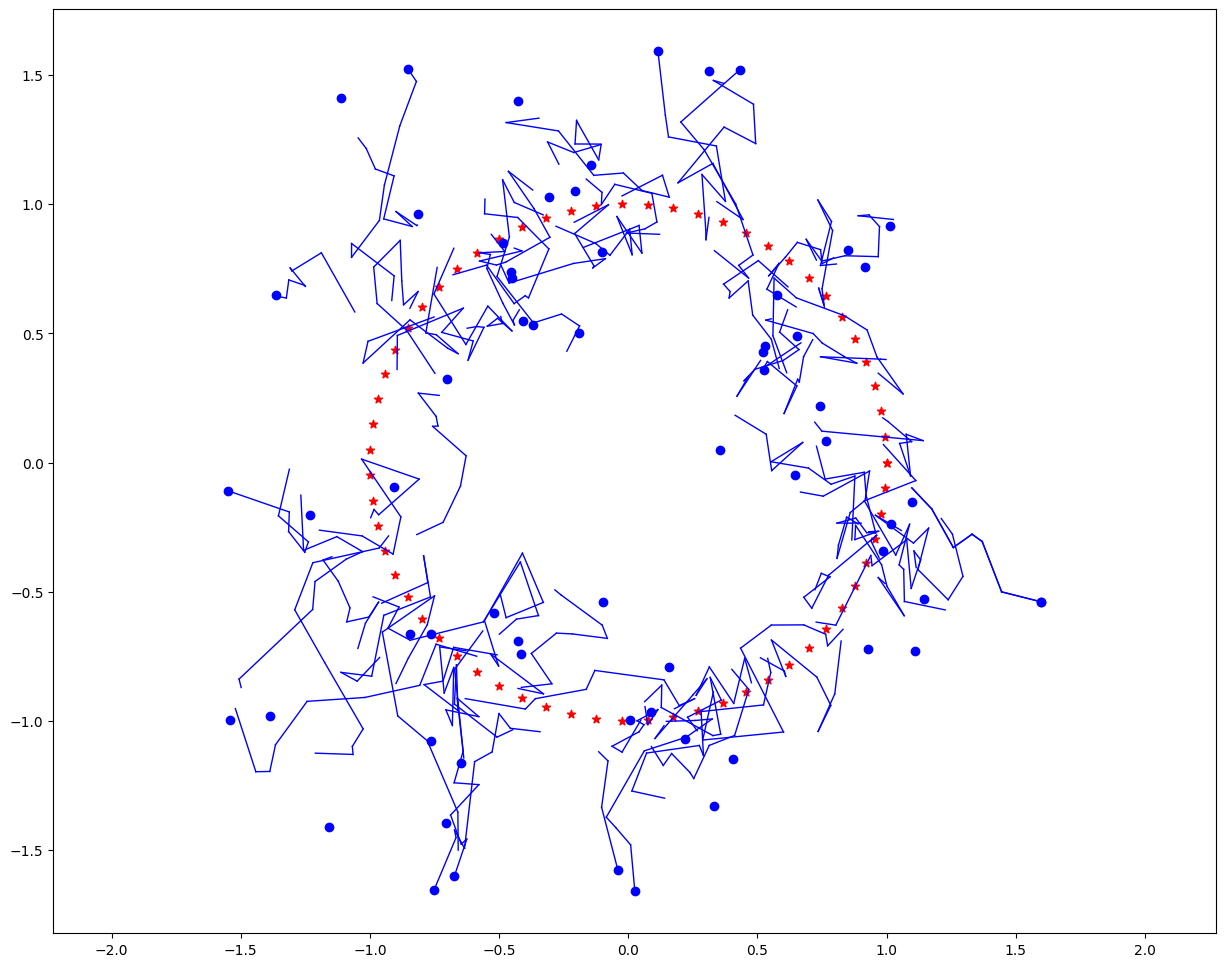

In [8]:
key, _ = jax.random.split(key)
_dW = jnp.sqrt(T / n_steps) * jax.random.normal(key, (n_steps, M.N, M.N, M.m))
Eulerian_step = setup()
(ts, qs, charts) = Eulerian_step(q0, 1.0, 1.0, dts(n_steps=n_steps), _dW)

M.plot()
M.plotx(q0, color='r', marker='*')
M.plot_path(zip(qs, charts))

In [42]:
qss = []
for i in range(1000):
    key, _ = jax.random.split(key)
    _dW_pixels = dW_pixels(key)
    (ts, qs, charts) = Eulerian_step(q0, kernel_amp_pixels, kernel_scale_pixels, dts(n_steps=n_steps), _dW_pixels)
    qss.append(qs)
qss = jnp.stack(qss)

In [46]:
disps = qss[:, 1, :] - qss[:, 0, :]

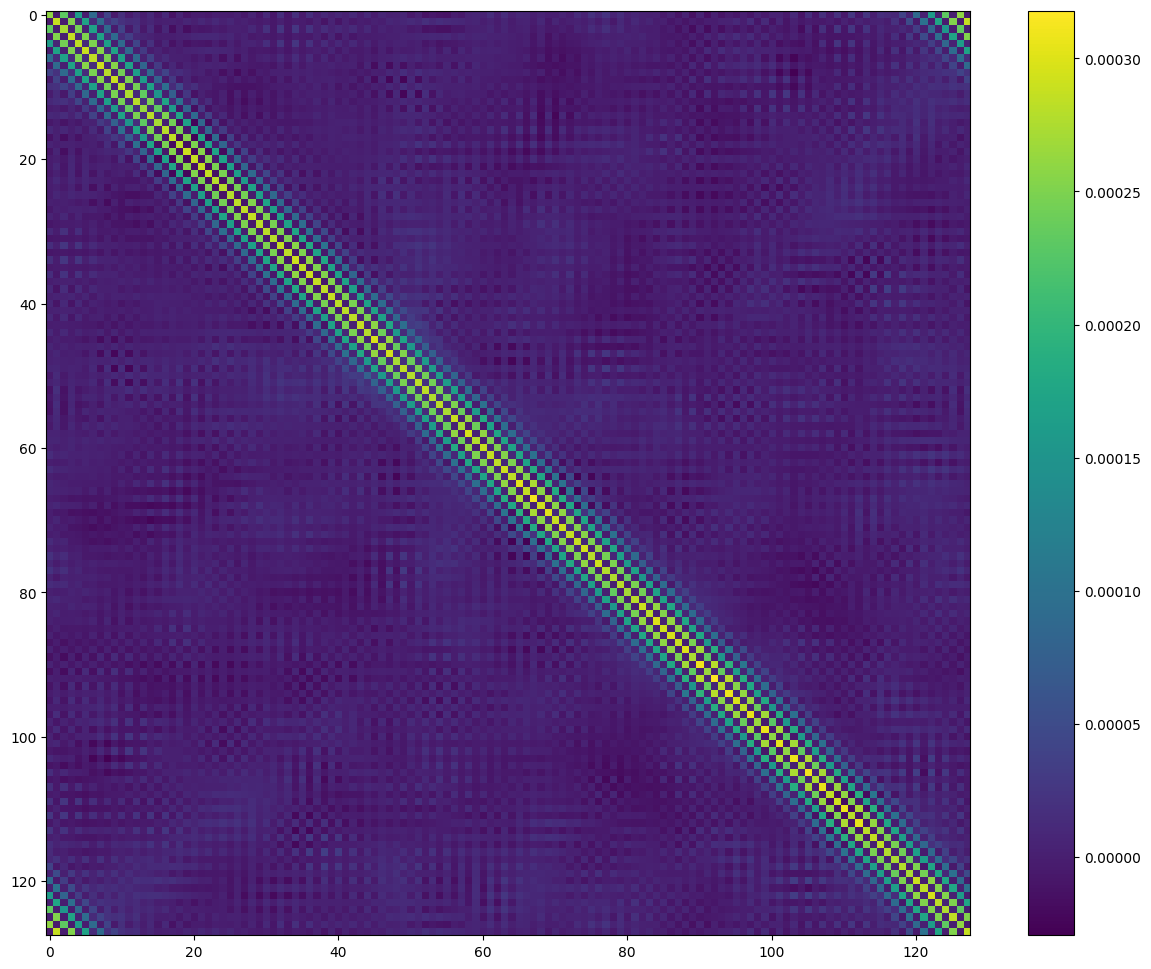

In [47]:
cov_matrix = jnp.cov(disps, rowvar=False)
plt.imshow(cov_matrix)
plt.colorbar()

/var/folders/3_/4nczgmtd41xg86smqjb11nn40000gn/T/ipykernel_49524/3977815898.py:19: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  make_square = lambda A: A.reshape((jnp.sqrt(A.size).astype('int'), jnp.sqrt(A.size).astype('int')))


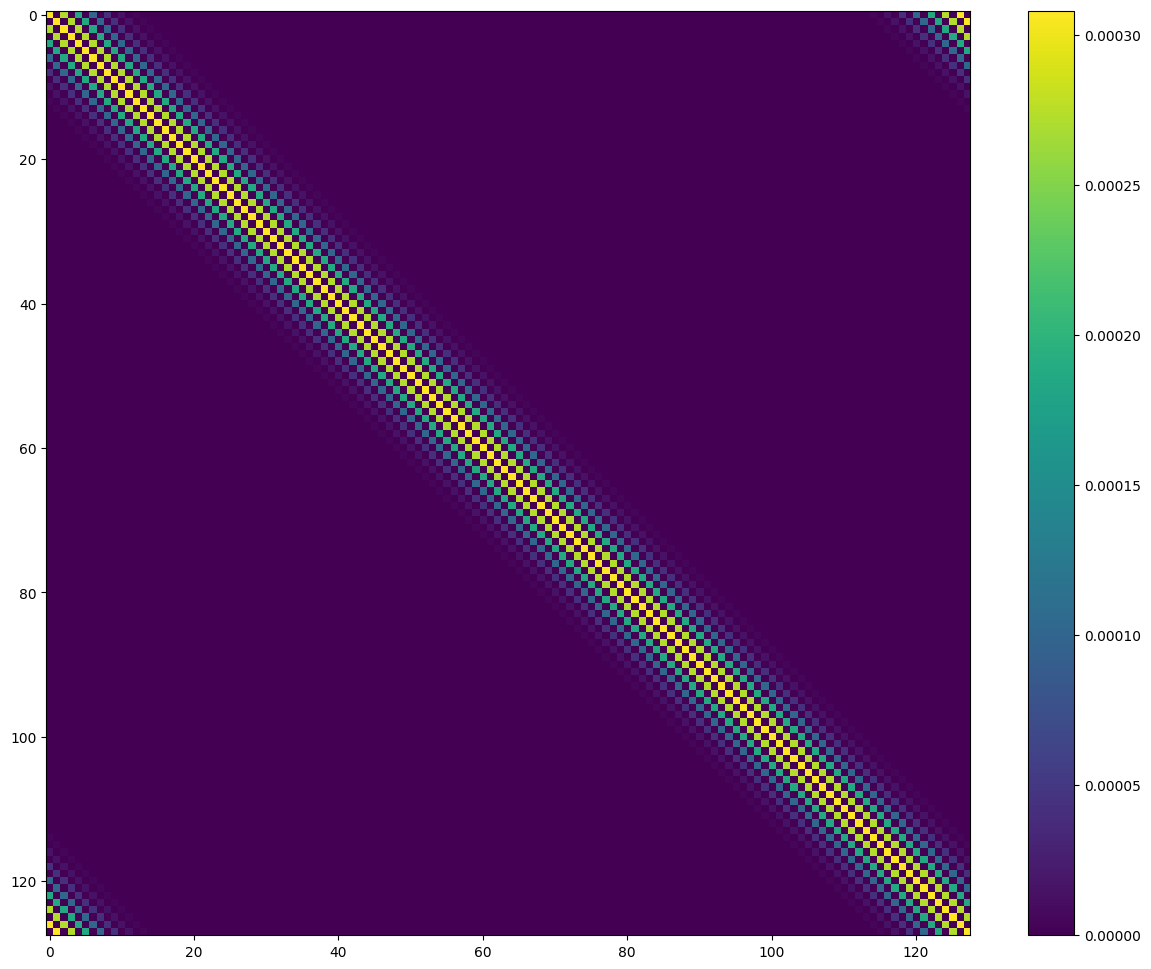

In [48]:
plt.imshow(Q_coords(q0[0], kernel_amp_coords, kernel_scale_coords) * (T / n_steps))
plt.colorbar()

In [100]:
def dW_covariance_estimation(kernel_amp_coords=1.0, kernel_scale_coords=0.1, sigma_deviation=3.0, coords_range=[-1.5, 1.5], dW_resolution=128):
    global key
    x_left, x_right = coords_range
    delta_p = (x_right - x_left) / dW_resolution 
    kernel_amp_pixels = kernel_amp_coords * delta_p
    kernel_scale_pixels = kernel_scale_coords / delta_p
    kernel_edge_pixels = kernel_scale_pixels * sigma_deviation
    kernel_dim_pixels = int(2 * kernel_edge_pixels) + 1
    kernel_span_pixels = jnp.linspace(-kernel_edge_pixels, kernel_edge_pixels, kernel_dim_pixels)
    print(f"kernel dim: {kernel_dim_pixels} x {kernel_dim_pixels}")

    # Empirical covariance of dW
    gaussian = lambda span, loc, scale: jnp.exp(-1.0 * ((span - loc) / scale)**2)
    gaussian_pixels = partial(gaussian, loc=0.)
    k_Q_half_pixels = lambda kernel_amp_pixels, kernel_scale_pixels: kernel_amp_pixels \
                                                                     * gaussian_pixels(span=kernel_span_pixels, scale=kernel_scale_pixels) \
                                                                     * gaussian_pixels(span=kernel_span_pixels[:, None], scale=kernel_scale_pixels)
    dW_pixels = lambda key: jax.random.normal(key, (dW_resolution, dW_resolution))
    Q_half_dW_pixels = lambda _dW_pixels, _Q_half_pixels: jsp.signal.convolve2d(_dW_pixels, _Q_half_pixels, mode='same')
    interpolate = lambda _Q_half_dW_pixels, x: jsp.ndimage.map_coordinates(_Q_half_dW_pixels.T, x.T, order=1)

    # Theoretical covariance of dW
    k_Q_pixels = lambda x, kernel_amp_pixels, kernel_scale_pixels: 0.5 * kernel_amp_pixels**2 * kernel_scale_pixels**2 * jnp.pi * jnp.exp(-0.5 / kernel_scale_pixels**2 * jnp.sum(jnp.square(x), 2)) 
    k_Q_coords = lambda q, kernel_amp_coords, kernel_scale_coords: 0.5 * kernel_amp_coords**2 * kernel_scale_coords**2 * jnp.pi * jnp.exp(-0.5 / kernel_scale_coords**2 * jnp.sum(jnp.square(q), 2)) 
    kQ_q_pixels = lambda x, kernel_amp_pixels, kernel_scale_pixels: k_Q_pixels(x[:, jnp.newaxis] - x[jnp.newaxis, :], kernel_amp_pixels, kernel_scale_pixels)
    kQ_q_coords = lambda q, kernel_amp_coords, kernel_scale_coords: k_Q_coords(q[:, jnp.newaxis] - q[jnp.newaxis, :], kernel_amp_coords, kernel_scale_coords)  

    _dWs = []
    _Q_half_dWs = []

    to_grid = lambda q: (q - x_left) / delta_p
    to_coords = lambda x: x * delta_p + x_left

    q = jnp.stack([jnp.cos(jnp.linspace(0., 2.0*jnp.pi, 64)), jnp.sin(jnp.linspace(0., 2.0*jnp.pi, 64))]).T
    x = to_grid(q)

    for i in range(1000):
        key, _ = jax.random.split(key)
        _dW = dW_pixels(key)
        _dWs.append(interpolate(_dW, x))
        _Q_half_dW = Q_half_dW_pixels(_dW, k_Q_half_pixels(kernel_amp_pixels, kernel_scale_pixels))
        _Q_half_dWs.append(interpolate(_Q_half_dW, x))

    fig, ax = plt.subplots(1, 4, figsize=(40, 10))
    im0 = ax[0].imshow(jnp.cov(jnp.stack(_dWs), rowvar=False))
    ax[0].set_title('Empirical Covariance of dW')
    plt.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(jnp.cov(jnp.stack(_Q_half_dWs), rowvar=False))
    ax[1].set_title('Empirical Covariance of dW convolved')
    plt.colorbar(im1, ax=ax[1])

    im2 = ax[2].imshow(kQ_q_pixels(x.reshape((-1, 2)), kernel_amp_pixels, kernel_scale_pixels))
    ax[2].set_title('Q matrix grid')
    plt.colorbar(im2, ax=ax[2])

    im3 = ax[3].imshow(kQ_q_coords(q.reshape((-1, 2)), kernel_amp_coords, kernel_scale_coords))
    ax[3].set_title('Q matrix coords')
    plt.colorbar(im3, ax=ax[3])


kernel dim: 26 x 26


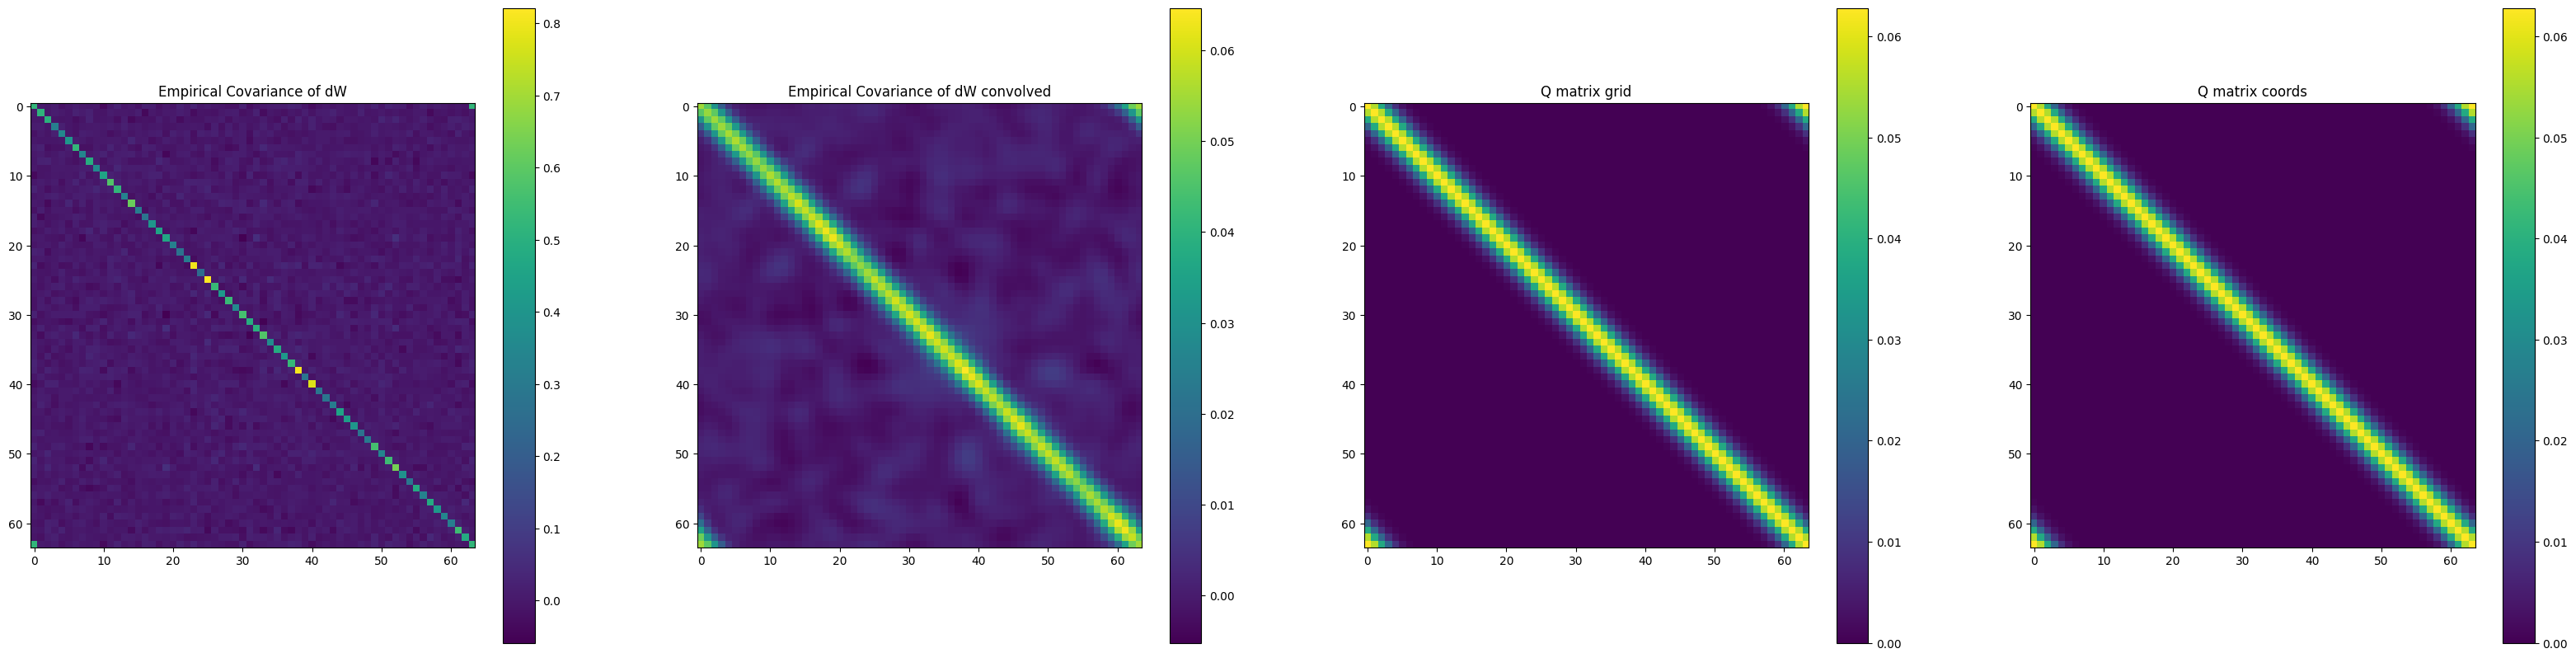

In [107]:
dW_covariance_estimation(kernel_scale_coords=0.2, dW_resolution=64)

kernel dim: 26 x 26


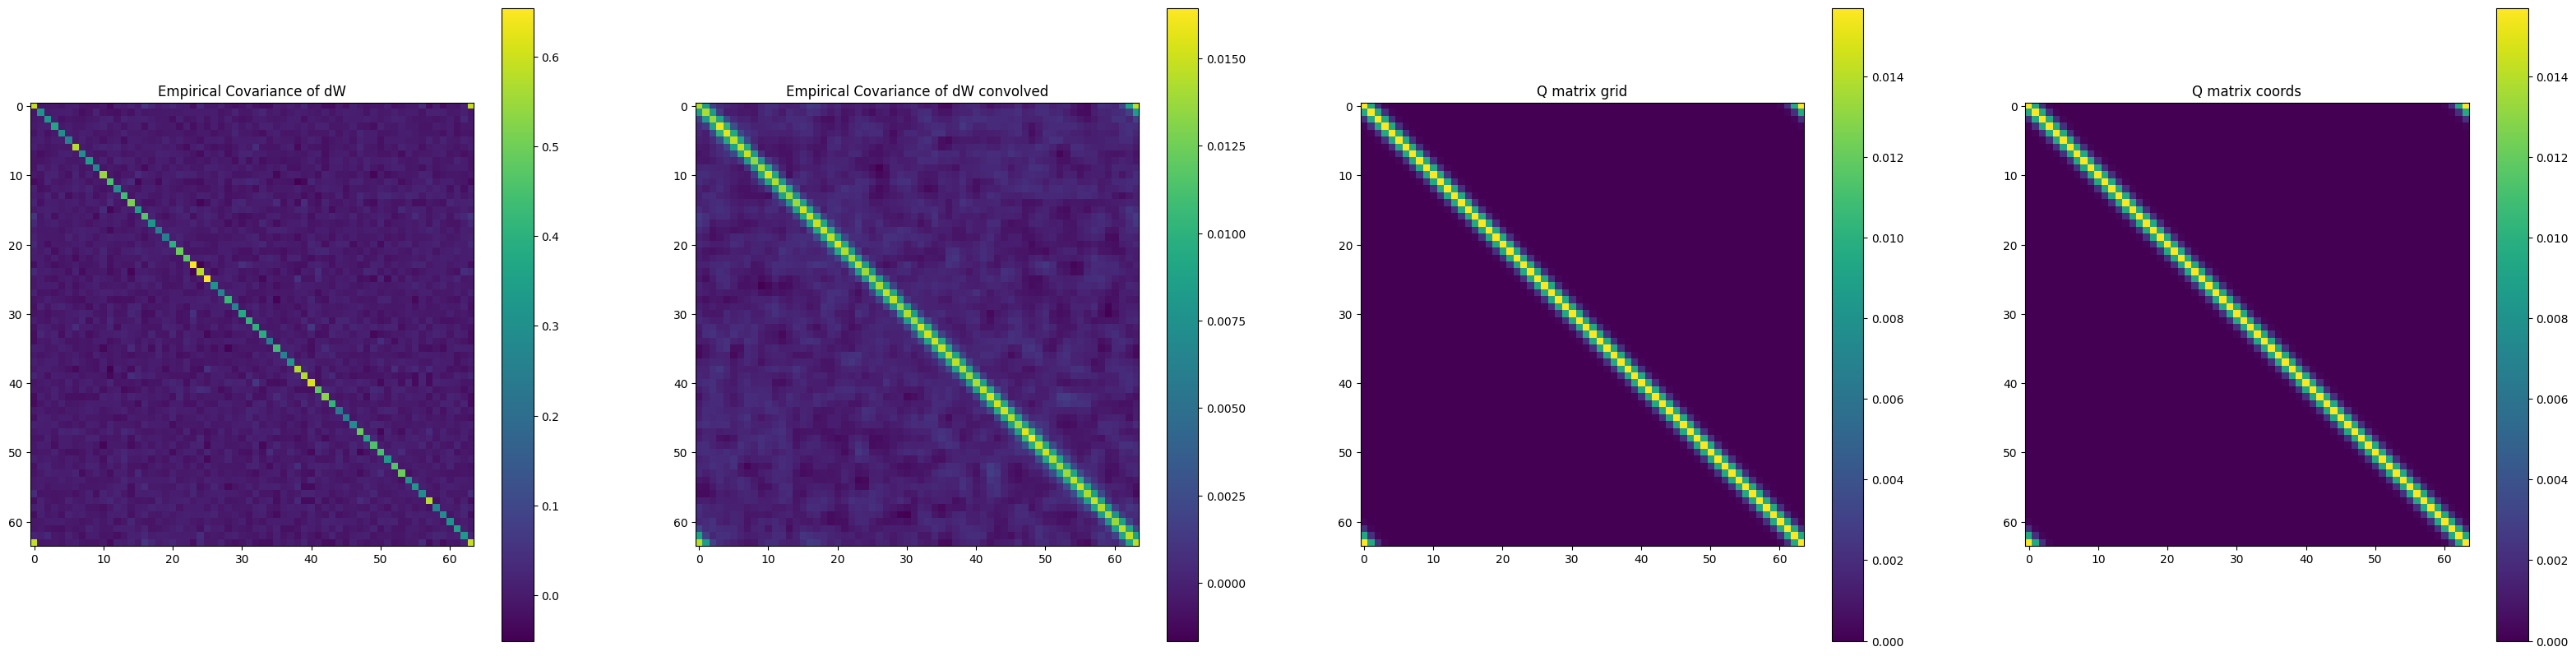

In [105]:
dW_covariance_estimation(kernel_scale_coords=0.1)

kernel dim: 129 x 129


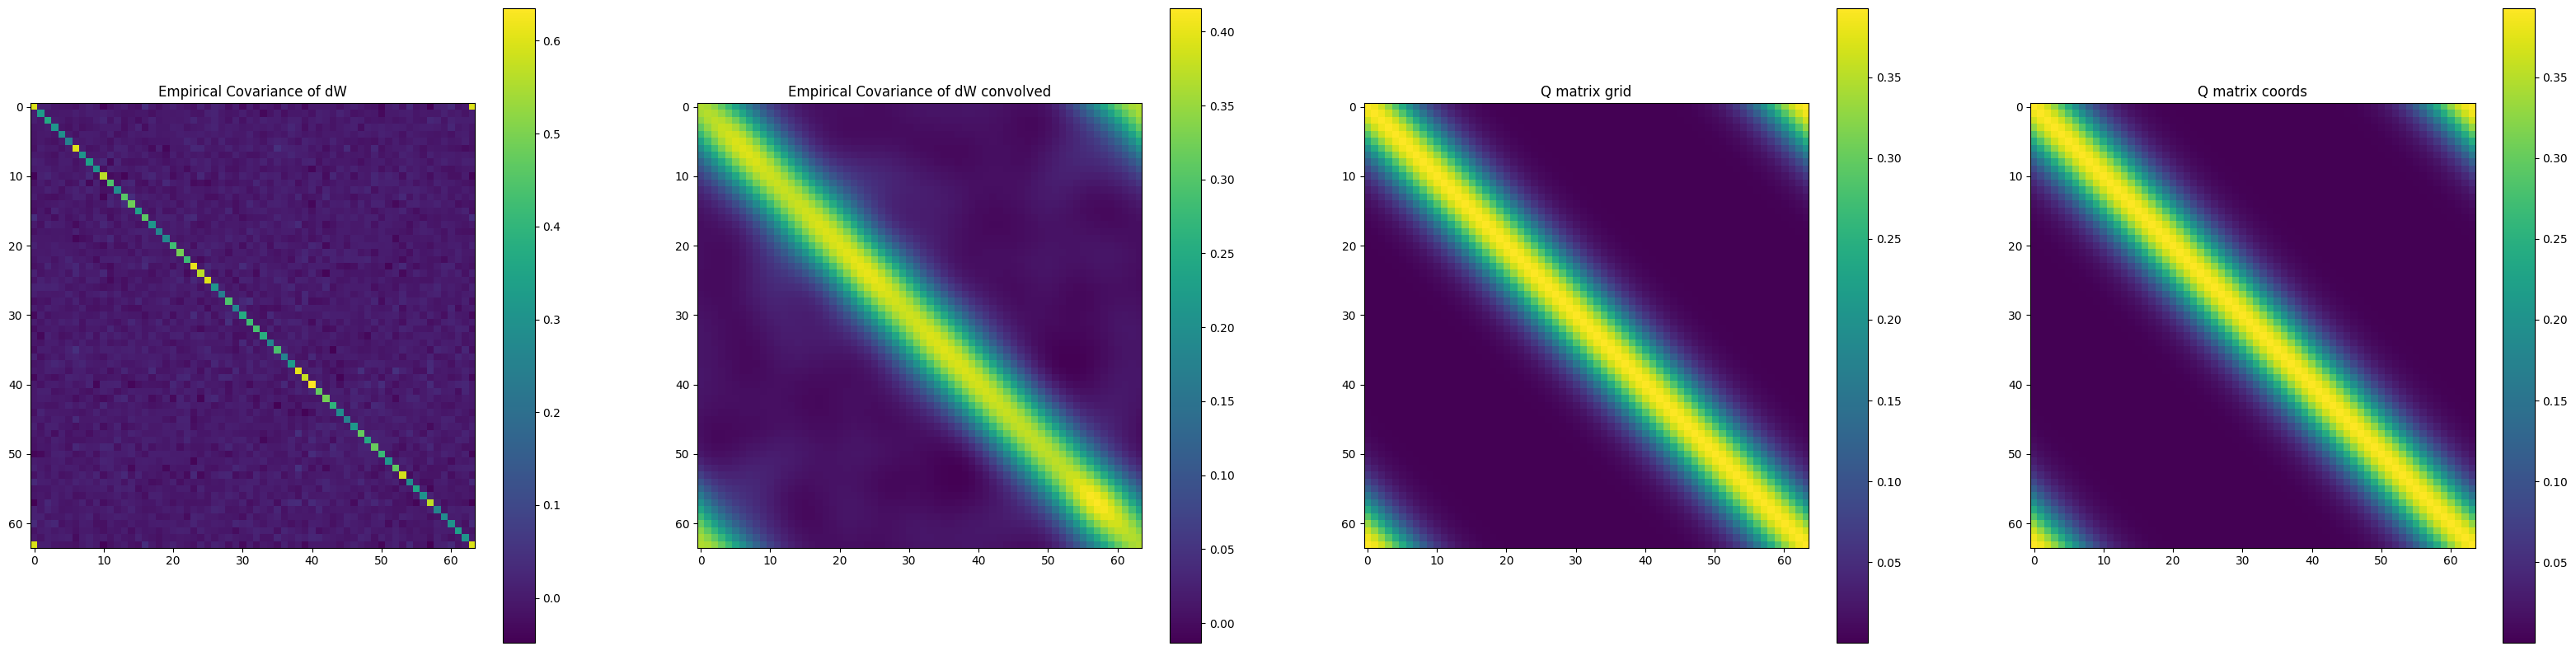

In [106]:
dW_covariance_estimation(kernel_scale_coords=0.5)

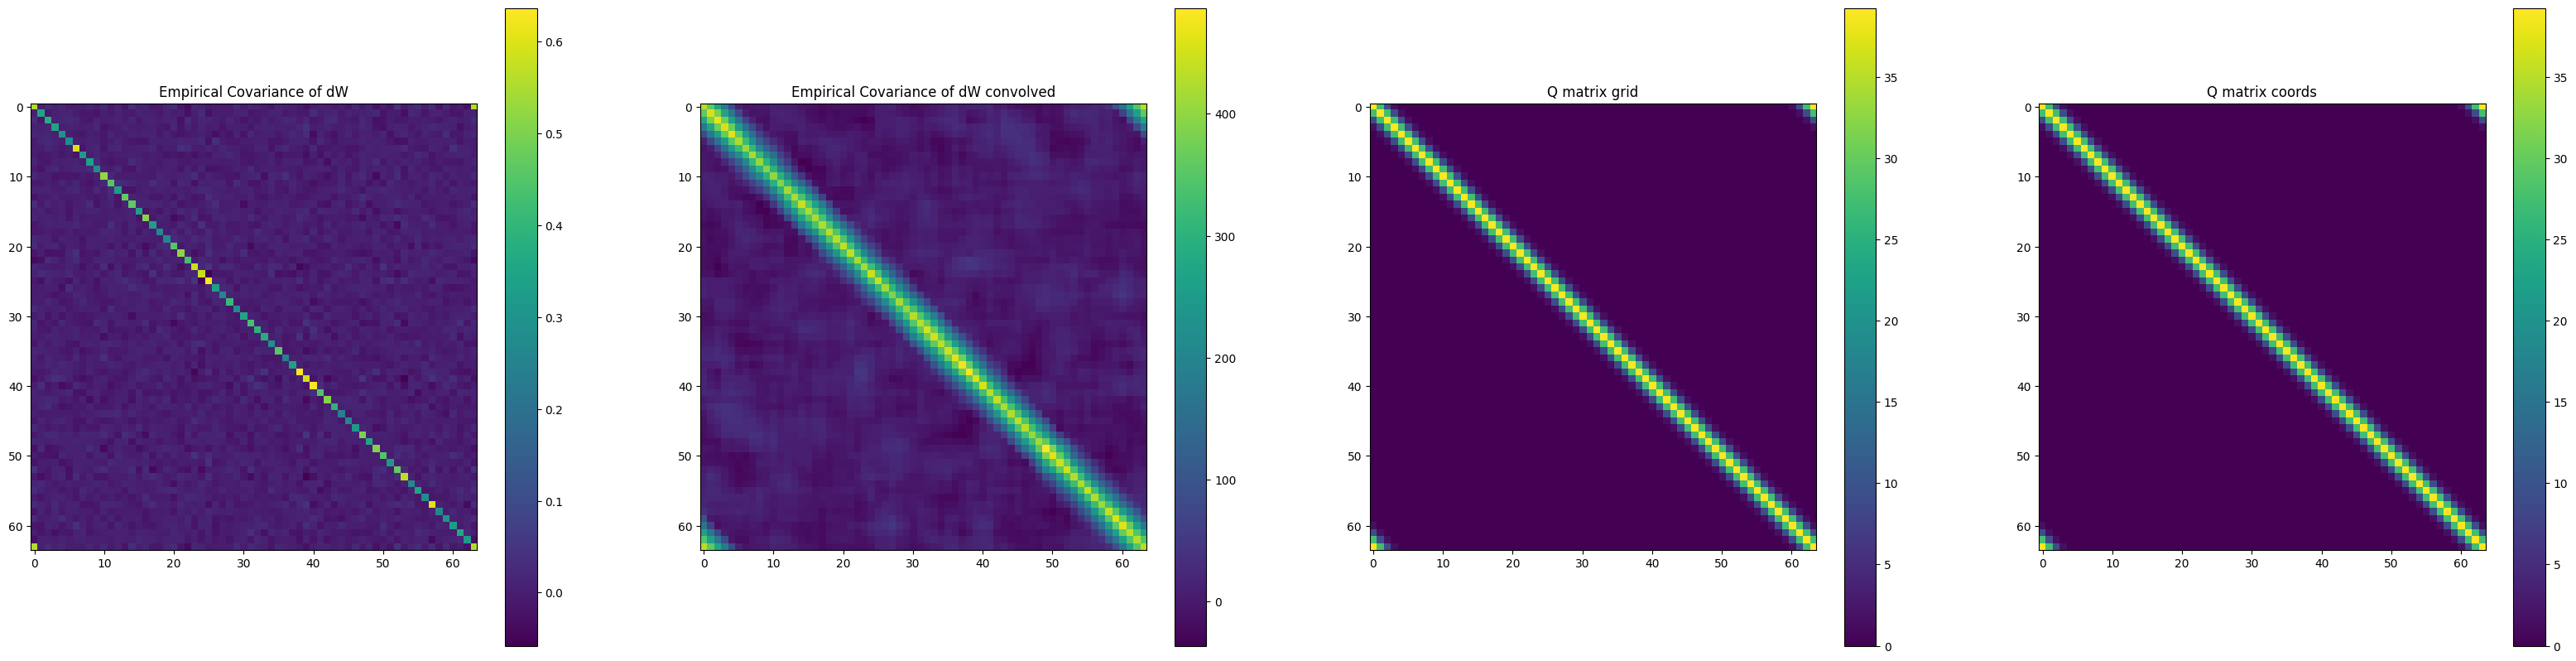

In [68]:
dW_covariance_estimation(21)

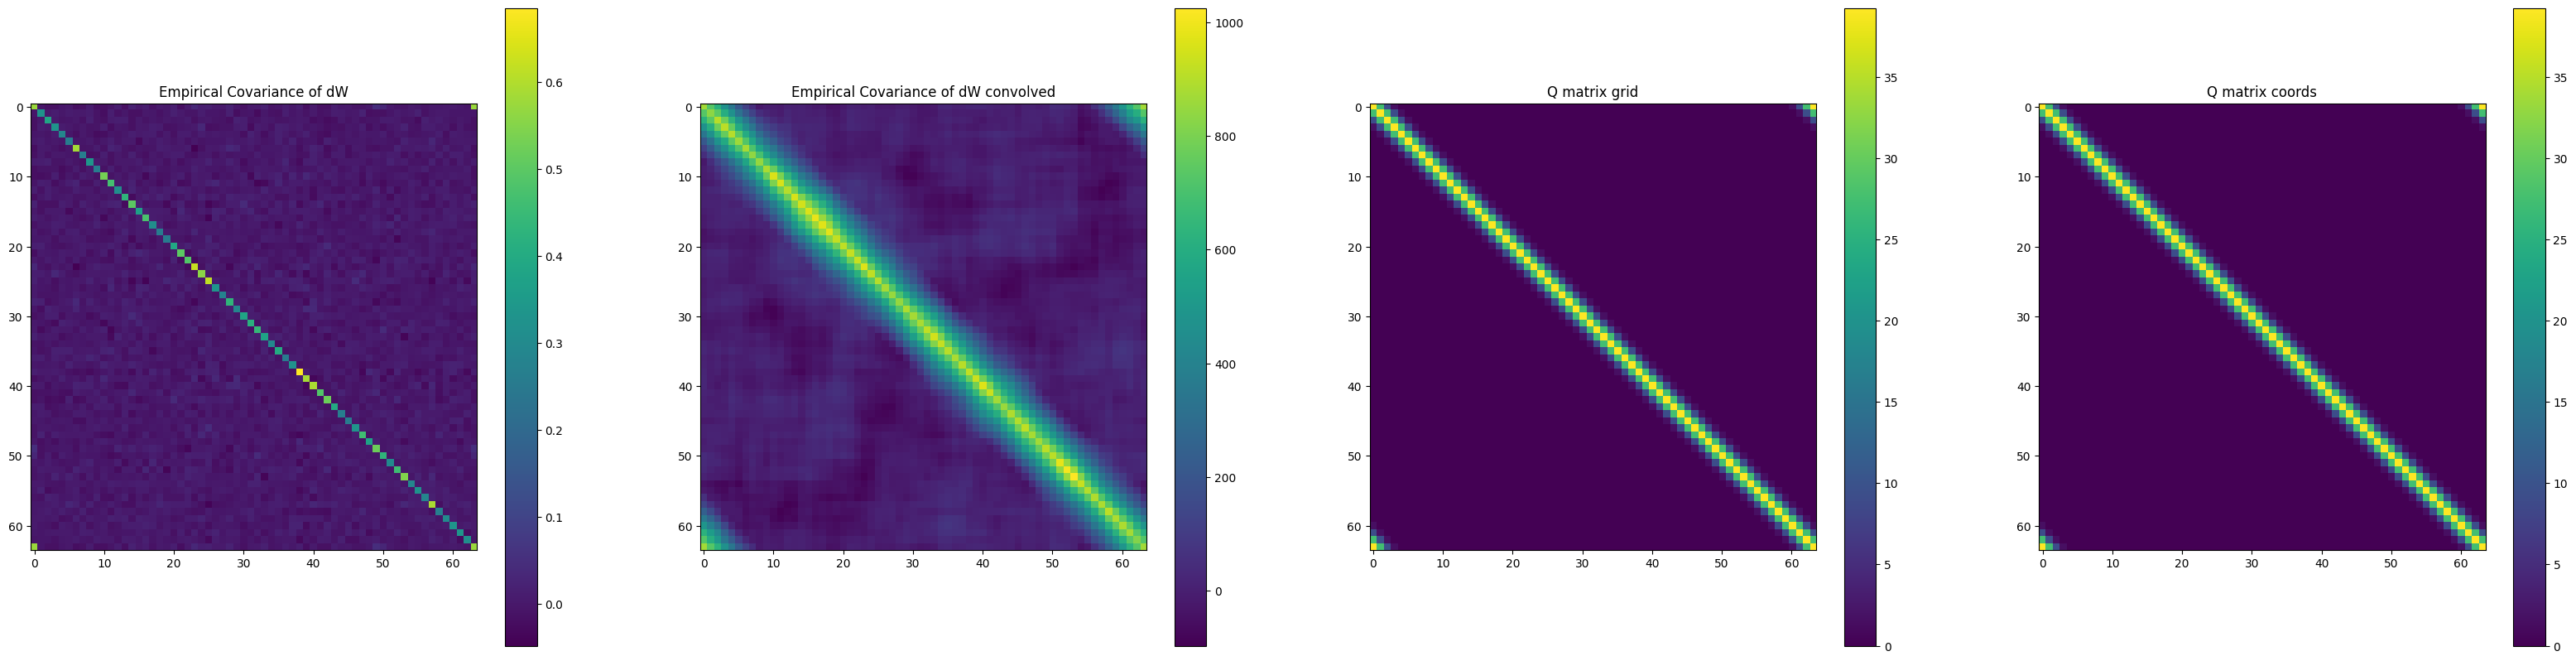

In [69]:
dW_covariance_estimation(31)